## Marine Data Analysis

### Import Required Libraries

In [1]:
import pandas as pd
from oceans.datasets import get_depth
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import requests
from haversine import haversine
import torch
import torch.nn as nn
import torch.optim as optim

### Define function for getting distance from beach

In [2]:
def get_dist(sea_point):
    url = 'https://nominatim.openstreetmap.org/reverse'
    params = {
        'format': 'jsonv2',
        'lat': sea_point[0],
        'lon': sea_point[1]
    }

    response = requests.get(url, params=params).json()

    shore_point = (float(response['lat']), float(response['lon']))

    distance = haversine(sea_point, shore_point)
    return distance

### Reading and processing marine plants Data from the Europe data folder

In [3]:
path = 'Data/Europe data/results'

In [4]:
eu_data = []

In [5]:
for i in range(96):
    filename = path + f" ({i}).csv"
    val_dict = {}

    with open(filename) as file:
        lines = file.readlines()
        val_dict['type'] = lines[0]

        for line in lines[1:]:
            line = line.strip()
            key_vals = line.replace('"', '').split('\t')
            if key_vals == ['']:
                break
            if "Latitude" in key_vals[0]:
                key_vals[0] = "Latitude"
            if "Longitude" in key_vals[0]:
                key_vals[0] = "Longitude"
            val_dict[key_vals[0]] = key_vals[1]

    eu_data.append(val_dict)

In [6]:
eu_data[37].keys()

dict_keys(['type', 'Status', 'Name', 'Commercial Readiness', 'Phase', 'Country', 'Sea', 'Region', 'Latitude', 'Longitude', 'Capacity [MW]', 'Energy source', 'Number of converters', '(Estimated) begin of construction', '(Estimated) commissioning', '(Estimated) decommissioning', 'Owner', 'Project developer', 'Operator', 'Converter manufacturer', 'Converter type', 'Converter working principle', 'Converter capacity [MW]', 'Website', 'geometry'])

In [7]:
eu_data[37]

{'type': 'Wave\n',
 'Status': 'under construction',
 'Name': 'mWave Demonstrator',
 'Commercial Readiness': 'pre-commercial project',
 'Phase': '1',
 'Country': 'United Kingdom',
 'Sea': 'Bristol Channel',
 'Region': 'META, East Pickard Bay, approx. 1 km from Freshwater West beach',
 'Latitude': '51.666',
 'Longitude': '-5.09',
 'Capacity [MW]': '1.5',
 'Energy source': 'marine energy (wave)',
 'Number of converters': '1',
 '(Estimated) begin of construction': '',
 '(Estimated) commissioning': '31.12.2021',
 '(Estimated) decommissioning': '31.12.2022',
 'Owner': 'Bombora Wave Power',
 'Project developer': 'Bombora Wave Power',
 'Operator': 'Bombora Wave Power',
 'Converter manufacturer': 'Bombora Wave Power',
 'Converter type': 'mWave',
 'Converter working principle': 'Submerged Pressure Differential',
 'Converter capacity [MW]': '1.5',
 'Website': 'https://bomborawave.com/latest-news/project/1-5mw-pembrokeshire-project/',
 'geometry': 'POINT (-566616.20813776 6739957.81664534)'}

### Reading and processing marine plants Data from the Europe data folder

In [8]:
path = 'Data/rest_data/results'

In [9]:
non_eu_data = []

In [10]:
for i in range(79):
    filename = path + f" ({i}).csv"
    val_dict = {}

    with open(filename) as file:
        lines = file.readlines()
        val_dict['type'] = lines[0]

        for line in lines[1:]:
            line = line.strip()
            key_vals = line.replace('"', '').split('\t')
            if key_vals == ['']:
                break
            if "Latitude" in key_vals[0]:
                key_vals[0] = "Latitude"
            if "Longitude" in key_vals[0]:
                key_vals[0] = "Longitude"
            val_dict[key_vals[0]] = key_vals[1]

    non_eu_data.append(val_dict)

In [11]:
non_eu_data[10]

{'type': 'OTEC\n',
 'Status': 'early planning',
 'Name': 'Virgin Islands - St. Croix',
 'Commercial Readiness': 'commercial project',
 'Phase': '',
 'Country': 'USA',
 'Sea': 'Carribean Sea',
 'Region': 'St. Croix',
 'Latitude': '17.735',
 'Longitude': '-64.783',
 'Capacity [MW]': '15',
 'Energy source': 'marine energy (OTEC)',
 'Number of converters': '',
 '(Estimated) begin of construction': '',
 '(Estimated) commissioning': '',
 '(Estimated) decommissioning': '',
 'Owner': 'Ocean Thermal Energy Corporation (OTE)',
 'Project developer': 'Ocean Thermal Energy Corporation (OTE)',
 'Operator': 'Ocean Thermal Energy Corporation (OTE)',
 'Converter manufacturer': '',
 'Converter type': '',
 'Converter working principle': '',
 'Converter capacity [MW]': '',
 'Website': 'http://otecorporation.com/projects/',
 'geometry': 'POINT (-7211610.57206064 2006553.93426781)'}

In [12]:
plant_data = eu_data + non_eu_data

### Reading the excel file containing all the collected data

In [13]:
df = pd.read_excel("Data/ml_data.xlsx", sheet_name=None)

In [14]:
list(df.keys())

['coastline',
 'beaches',
 'marine_energy_capacity_and_gene',
 'electricity_power_consumption',
 'GDP',
 'population',
 'renewable_energy_percentage',
 'purchase_parity',
 'electricity_cost',
 'inflation',
 'Series - Metadata',
 'Data']

In [114]:
df['beaches']

,Top beach coordinates,Latitude,Longitude,y,round_lat,round_long
0,Australia,-20.282677,149.034912,0,-20.5,149.0
1,Australia,-20.278610,149.036392,0,-20.5,149.0
2,Australia,-33.890842,151.274292,0,-34.0,151.5
3,Brazil,-3.854703,-32.443741,0,-4.0,-32.5
4,France,44.589123,-1.223570,0,44.5,-1.0
5,India,8.894748,76.553513,0,9.0,76.5
6,India,17.714294,83.323685,0,17.5,83.5
7,India,18.954269,72.811501,0,19.0,73.0
8,Indonesia,38.790527,-9.492289,0,39.0,-9.5
9,Indonesia,-8.750644,115.474693,0,-9.0,115.5


In [ ]:
for point in plant_data:
    point['dist'] = get_dist((float(point["Latitude"]), float(point["Longitude"])))

In [16]:
for point in plant_data:
    point['round_lat'] = round(2*float(point["Latitude"]))/2
    point['round_long'] = round(2*float(point["Longitude"]))/2

In [17]:
eu_data[0]['depth']

KeyError: 'depth'

In [19]:
eu_data[65]['dist']

KeyError: 'dist'

In [17]:
df_plants = pd.DataFrame(columns=['round_lat', 'round_long', 'y'])

for data in plant_data:
    df_plants = df_plants.append({'round_lat': data['round_lat'], 'round_long': data['round_long'], 'y': 1}, ignore_index=True)

/tmp/ipykernel_47832/380141424.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plants = df_plants.append({'round_lat': data['round_lat'], 'round_long': data['round_long'], 'y': 1}, ignore_index=True)
/tmp/ipykernel_47832/380141424.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plants = df_plants.append({'round_lat': data['round_lat'], 'round_long': data['round_long'], 'y': 1}, ignore_index=True)
/tmp/ipykernel_47832/380141424.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plants = df_plants.append({'round_lat': data['round_lat'], 'round_long': data['round_long'], 'y': 1}, ignore_index=True)
/tmp/ipykernel_47832/380141424.py:4: FutureWarning: The frame.append method is deprecated and will be removed fr

### Reading the marine .nc data

In [18]:
file = nc.Dataset('Data/adaptor.mars.internal-1681974049.4026587-29692-1-dd9a618f-4443-456b-9015-a189e9b4145c.nc', 'r')
file.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (720,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (361,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (264,)
 filling on, default _FillValue of -2147483647 used,
 'mwd': <class 'netCDF4._netCDF4.Variable'>
 int16 mwd(time, latitude, longitude)
     scale_factor: 0.005493459190347737
     add_offset: 179.99872524746002
     _FillValue: -32767
     missing_value: -32767
     units: Degree true
     long_name: Mean wave dire

### Get all the featurs values

In [19]:
longitude = file.variables['longitude']
latitude = file.variables['latitude']
time = file.variables['time']
mwd = file.variables['mwd']
mwp = file.variables['mwp']
wmb = file.variables['wmb']
phioc = file.variables['phioc']
phiaw = file.variables['phiaw']
swh = file.variables['swh']

In [20]:
longitude = longitude[:]
latitude = latitude[:]
time = time[:]
mwd = mwd[:]
mwp = mwp[:]
wmb = wmb[:]
phioc = phioc[:]
phiaw = phiaw[:]
swh = swh[:]

### Define function for exponentially weighted mean average

In [23]:
def ewma(x):
    return pd.Series(x).ewm(alpha=0.05).mean().values[-1]

### Get ewma for all the features

In [24]:
mwd = np.apply_along_axis(ewma, axis=0, arr=mwd)
mwp = np.apply_along_axis(ewma, axis=0, arr=mwp)
wmb = np.apply_along_axis(ewma, axis=0, arr=wmb)
phioc = np.apply_along_axis(ewma, axis=0, arr=phioc)
phiaw = np.apply_along_axis(ewma, axis=0, arr=phiaw)
swh = np.apply_along_axis(ewma, axis=0, arr=swh)

In [101]:
masked_data = np.ma.masked_less(phioc.data, -13000)

In [103]:
type(masked_data)

numpy.ma.core.MaskedArray

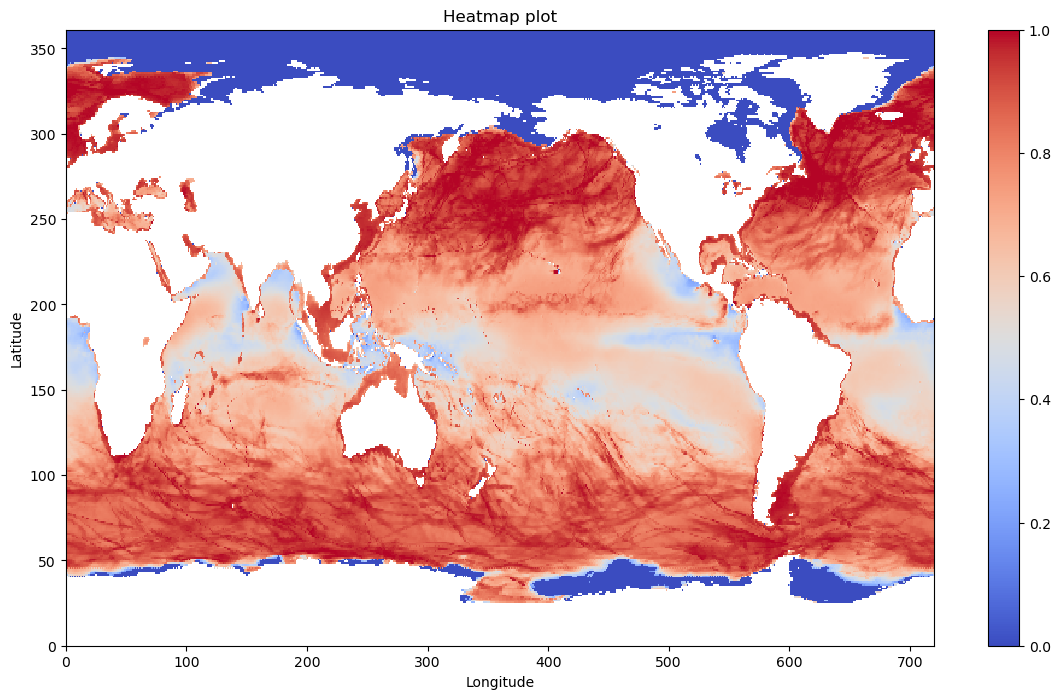

In [22]:
latitude.data.tolist()

[90.0,
 89.5,
 89.0,
 88.5,
 88.0,
 87.5,
 87.0,
 86.5,
 86.0,
 85.5,
 85.0,
 84.5,
 84.0,
 83.5,
 83.0,
 82.5,
 82.0,
 81.5,
 81.0,
 80.5,
 80.0,
 79.5,
 79.0,
 78.5,
 78.0,
 77.5,
 77.0,
 76.5,
 76.0,
 75.5,
 75.0,
 74.5,
 74.0,
 73.5,
 73.0,
 72.5,
 72.0,
 71.5,
 71.0,
 70.5,
 70.0,
 69.5,
 69.0,
 68.5,
 68.0,
 67.5,
 67.0,
 66.5,
 66.0,
 65.5,
 65.0,
 64.5,
 64.0,
 63.5,
 63.0,
 62.5,
 62.0,
 61.5,
 61.0,
 60.5,
 60.0,
 59.5,
 59.0,
 58.5,
 58.0,
 57.5,
 57.0,
 56.5,
 56.0,
 55.5,
 55.0,
 54.5,
 54.0,
 53.5,
 53.0,
 52.5,
 52.0,
 51.5,
 51.0,
 50.5,
 50.0,
 49.5,
 49.0,
 48.5,
 48.0,
 47.5,
 47.0,
 46.5,
 46.0,
 45.5,
 45.0,
 44.5,
 44.0,
 43.5,
 43.0,
 42.5,
 42.0,
 41.5,
 41.0,
 40.5,
 40.0,
 39.5,
 39.0,
 38.5,
 38.0,
 37.5,
 37.0,
 36.5,
 36.0,
 35.5,
 35.0,
 34.5,
 34.0,
 33.5,
 33.0,
 32.5,
 32.0,
 31.5,
 31.0,
 30.5,
 30.0,
 29.5,
 29.0,
 28.5,
 28.0,
 27.5,
 27.0,
 26.5,
 26.0,
 25.5,
 25.0,
 24.5,
 24.0,
 23.5,
 23.0,
 22.5,
 22.0,
 21.5,
 21.0,
 20.5,
 20.0,
 19.5,
 19.0,

In [28]:
len(longitude)

720

In [29]:
# for tm in range(len(time)):
#     for lat in range(len(latitude)):
#         for long in range(len(longitude)):
#             wmb.data[tm][lat][long]

In [30]:
# for lat in range(len(latitude)):
#     for long in range(len(longitude)):
#         wmb.data[-1][lat][long]

In [31]:
X, Y = np.meshgrid(latitude.data, longitude.data)

# # plot the pcolormesh
# plt.pcolormesh(X, Y, wmb.data[-1], cmap='jet')
# plt.colorbar()

## ML model

In [23]:
def val_round(val_round):
    return round(2*float(val_round))/2

In [24]:
def update_long(long):
    if long < 0:
        long+=180
    return long

In [25]:
# inputs
x_train = []
y_train = []

In [26]:
df_beach =  df['beaches']
df_beach['y'] = 0
df_beach['round_lat'] = df_beach['Latitude'].apply(val_round)
df_beach['round_long'] = df_beach['Longitude'].apply(val_round)
df_beach

,Top beach coordinates,Latitude,Longitude,y,round_lat,round_long
0,Australia,-20.282677,149.034912,0,-20.5,149.0
1,Australia,-20.278610,149.036392,0,-20.5,149.0
2,Australia,-33.890842,151.274292,0,-34.0,151.5
3,Brazil,-3.854703,-32.443741,0,-4.0,-32.5
4,France,44.589123,-1.223570,0,44.5,-1.0
5,India,8.894748,76.553513,0,9.0,76.5
6,India,17.714294,83.323685,0,17.5,83.5
7,India,18.954269,72.811501,0,19.0,73.0
8,Indonesia,38.790527,-9.492289,0,39.0,-9.5
9,Indonesia,-8.750644,115.474693,0,-9.0,115.5


In [27]:
df_train = pd.concat([df_plants, df_beach])[['round_lat','round_long','y']]
df_train['round_long'] = df_train['round_long'].apply(update_long)

,round_lat,round_long,y
0,60.5,179.0,1.0
1,59.0,177.0,1.0
2,59.0,177.0,1.0
3,59.0,177.0,1.0
4,59.0,177.0,1.0
...,...,...,...
47,46.0,56.0,0.0
48,26.0,100.0,0.0
49,40.0,106.0,0.0
50,34.0,101.5,0.0


In [28]:
wmb.data[0][latitude.data.tolist().index(df_train.iloc[0]['round_lat'])][longitude.data.tolist().index(df_train.iloc[0]['round_long'])]

995.9967497291441

In [29]:
def update_wmb(round_lat, round_long):
    return wmb.data[0][latitude.data.tolist().index(round_lat)][longitude.data.tolist().index(round_long)]

def update_phioc(round_lat, round_long):
    return phioc.data[0][latitude.data.tolist().index(round_lat)][longitude.data.tolist().index(round_long)]

def update_mwp(round_lat, round_long):
    return mwp.data[0][latitude.data.tolist().index(round_lat)][longitude.data.tolist().index(round_long)]

def update_phiaw(round_lat, round_long):
    return phiaw.data[0][latitude.data.tolist().index(round_lat)][longitude.data.tolist().index(round_long)]

def update_swh(round_lat, round_long):
    return swh.data[0][latitude.data.tolist().index(round_lat)][longitude.data.tolist().index(round_long)]

In [30]:
df_train['wmb'] = df_train.apply(lambda row: update_wmb(row['round_lat'], row['round_long']), axis=1)
df_train['phioc'] = df_train.apply(lambda row: update_phioc(row['round_lat'], row['round_long']), axis=1)
df_train['mwp'] = df_train.apply(lambda row: update_mwp(row['round_lat'], row['round_long']), axis=1)
df_train['phiaw'] = df_train.apply(lambda row: update_phiaw(row['round_lat'], row['round_long']), axis=1)
df_train['swh'] = df_train.apply(lambda row: update_swh(row['round_lat'], row['round_long']), axis=1)

In [31]:
df_train

,round_lat,round_long,y,wmb,phioc,mwp,phiaw,swh
0,60.5,179.0,1.0,995.99675,-3.674569,7.112516,3.982748,2.825140
1,59.0,177.0,1.0,999.00000,-6.365684,7.726033,3.917098,3.208017
2,59.0,177.0,1.0,999.00000,-6.365684,7.726033,3.917098,3.208017
3,59.0,177.0,1.0,999.00000,-6.365684,7.726033,3.917098,3.208017
4,59.0,177.0,1.0,999.00000,-6.365684,7.726033,3.917098,3.208017
...,...,...,...,...,...,...,...,...
47,46.0,56.0,0.0,-32767.00000,-32767.000000,-32767.000000,-32767.000000,-32767.000000
48,26.0,100.0,0.0,-32767.00000,-32767.000000,-32767.000000,-32767.000000,-32767.000000
49,40.0,106.0,0.0,-32767.00000,-32767.000000,-32767.000000,-32767.000000,-32767.000000
50,34.0,101.5,0.0,-32767.00000,-32767.000000,-32767.000000,-32767.000000,-32767.000000


In [32]:
x_train = df_train[['wmb', 'phioc', 'mwp', 'phiaw', 'swh']].values
y_train = df_train[['y']].values

In [33]:
x_train[0]

array([995.99674973,  -3.67456881,   7.11251576,   3.98274815,
         2.82514012])

In [34]:
y_train

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [35]:
# define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [36]:
# create the neural network
net = Net()

# define the loss function
criterion = nn.BCELoss()

# define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)

# define the training data
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()


In [37]:
# train the network
for epoch in range(500):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print('Epoch: %d | Loss: %.3f' % (epoch+1, loss.item()))

Epoch: 1 | Loss: 54.403
Epoch: 2 | Loss: 54.294
Epoch: 3 | Loss: 54.185
Epoch: 4 | Loss: 54.516
Epoch: 5 | Loss: 54.407
Epoch: 6 | Loss: 54.297
Epoch: 7 | Loss: 54.188
Epoch: 8 | Loss: 54.078
Epoch: 9 | Loss: 53.968
Epoch: 10 | Loss: 53.858
Epoch: 11 | Loss: 53.748
Epoch: 12 | Loss: 53.638
Epoch: 13 | Loss: 53.471
Epoch: 14 | Loss: 53.349
Epoch: 15 | Loss: 53.227
Epoch: 16 | Loss: 53.107
Epoch: 17 | Loss: 52.988
Epoch: 18 | Loss: 52.869
Epoch: 19 | Loss: 52.752
Epoch: 20 | Loss: 52.636
Epoch: 21 | Loss: 52.519
Epoch: 22 | Loss: 52.401
Epoch: 23 | Loss: 52.283
Epoch: 24 | Loss: 52.165
Epoch: 25 | Loss: 52.046
Epoch: 26 | Loss: 51.927
Epoch: 27 | Loss: 51.808
Epoch: 28 | Loss: 51.690
Epoch: 29 | Loss: 51.571
Epoch: 30 | Loss: 60.264
Epoch: 31 | Loss: 59.948
Epoch: 32 | Loss: 55.194
Epoch: 33 | Loss: 50.573
Epoch: 34 | Loss: 46.137
Epoch: 35 | Loss: 41.740
Epoch: 36 | Loss: 37.410
Epoch: 37 | Loss: 33.189
Epoch: 38 | Loss: 30.652
Epoch: 39 | Loss: 27.491
Epoch: 40 | Loss: 24.970
Epoch: 41

In [44]:
round_lat = []
round_long = []
for lat in latitude.data:
    for long in longitude.data:
        round_lat.append(lat)
        round_long.append(long)
        
df_test = pd.DataFrame({'round_lat' : round_lat, 'round_long':round_long})

In [45]:
df_test

,round_lat,round_long
0,90.0,0.0
1,90.0,0.5
2,90.0,1.0
3,90.0,1.5
4,90.0,2.0
...,...,...
259915,-90.0,357.5
259916,-90.0,358.0
259917,-90.0,358.5
259918,-90.0,359.0


In [46]:
df_test['wmb'] = df_test.apply(lambda row: update_wmb(row['round_lat'], row['round_long']), axis=1)
df_test['phioc'] = df_test.apply(lambda row: update_phioc(row['round_lat'], row['round_long']), axis=1)
df_test['mwp'] = df_test.apply(lambda row: update_mwp(row['round_lat'], row['round_long']), axis=1)
df_test['phiaw'] = df_test.apply(lambda row: update_phiaw(row['round_lat'], row['round_long']), axis=1)
df_test['swh'] = df_test.apply(lambda row: update_swh(row['round_lat'], row['round_long']), axis=1)

In [48]:
x_test = df_test[['wmb', 'phioc', 'mwp', 'phiaw', 'swh']].values

In [49]:
test_inp = torch.tensor(x_test).float()
result = net(test_inp)

In [52]:
new_result = result.view(len(latitude), len(longitude))

In [113]:
for par in net.parameters():
    print(par)

Parameter containing:
tensor([[-0.0021, -0.8136, -0.0993,  0.1077,  0.2699]], requires_grad=True)
Parameter containing:
tensor([-0.0818], requires_grad=True)


In [ ]:
# masked_data = np.ma.masked_greater(new_result.detach().numpy(), 0.95)

mask = np.ma.masked_less(phioc.data[10], -13000)
masked_data = np.ma.masked_array(new_result.detach().numpy(), mask.mask)

fig, ax = plt.subplots(figsize=(14,8))
heatmap = ax.pcolormesh(np.flip(masked_data, axis=0), cmap='coolwarm')

# Add a color bar
cbar = fig.colorbar(heatmap)

# Set the plot title and axis labels
ax.set_title('Heatmap plot')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Show the plot
plt.show()


In [ ]:
# Close the file
file.close()

In [ ]:
time x latitude x longitude